# Networks and their Structure Assignment

## Network Science Topic 1

Note that the networks in this exercise are all directed.

1. Obtain the code and dataset and load ``citation_graph`` from ``topic1b.ipynb`` and, from ``topic1e.ipynb``, the PA graph ``EX_GRAPH_PA1`` used to model it.  Using the function ``local_clustering_coefficient`` in ``NatSfunctions.ipynb``, create two plots showing the normalized distribution of the local clustering coefficients for these two graphs.  To achieve this, round each value to two decimal places.


In [10]:
import random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%run NatSfunctions.ipynb

In [7]:
citation_graph = load_graph("alg_phys-cite.txt")
EX_GRAPH_PA1 = make_PA_Graph(27770, 13)

Loaded graph with 27770 nodes


In [8]:
def clustering_coefficient_distribution(graph):
    """
    Takes a graph and computes the unnormalised distribution of the local clustering coefficients of the graph.
    Returns a dictionary whose keys correspond to local clustering coefficents of nodes and values are the number of nodes
    with that clustering coefficient. The keys are rounded to 2 DPs.
    """
    
    # initialise dictionary for coefficient distribution
    coefficient_distribution = {}
    
    # consider each vertex
    for vertex in graph:
        
        # calculate the local clustering coefficient of this vertex and round to 2 DP
        coefficient = local_clustering_coefficient(graph, vertex)
        rounded_coefficient = round(coefficient, 2)
        
        # update coefficient distribution
        if rounded_coefficient not in coefficient_distribution:
            coefficient_distribution[rounded_coefficient] = 1
        else:
            coefficient_distribution[rounded_coefficient] += 1
    
    return coefficient_distribution

In [45]:
# normalise the distribution
def normalise_coefficient_distribution(graph):

    coefficient_distribution = clustering_coefficient_distribution(graph)
    normalised_coefficient_distribution = {}

    for coefficient in coefficient_distribution:
        normalised_coefficient_distribution[coefficient] = coefficient_distribution[coefficient] / 27770.0
    
    return normalised_coefficient_distribution

In [50]:
def plot_distributions(normalised_coefficient_distribution1, normalised_coefficient_distribution2):

    xdata1 = []
    xdata2 = []
    
    ydata1 = []
    ydata2 = []
    
    for coefficient in normalised_coefficient_distribution1:
        xdata1 += [coefficient]
        ydata1 += [normalised_coefficient_distribution1[coefficient]]
    
    for coefficient in normalised_coefficient_distribution2:
        xdata2 += [coefficient]
        ydata2 += [normalised_coefficient_distribution2[coefficient]]

    # plot the distribution
    plt.subplot(1, 2, 1)
    plt.loglog(xdata1, ydata1, marker='.', linestyle='None', color='b')
    plt.title('Local Clustering Coefficient Distribution of Citation Graph')
    plt.xlabel('Local Clustering Coefficient')
    plt.ylabel('Normalised Rate')

    plt.subplot(1, 2, 2)
    plt.loglog(xdata2, ydata2, marker='.', linestyle='None', color='b')
    plt.title('Local Clustering Coefficient Distribution of PA Graph')
    plt.xlabel('Local Clustering Coefficient')
    plt.ylabel('Normalised Rate')
    
    plt.rcParams["figure.figsize"] = (20, 5)

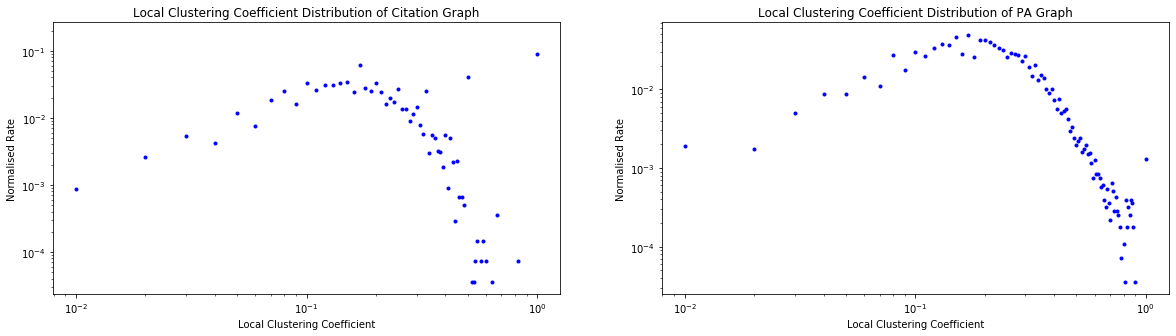

In [52]:
# call functions and plot distributions
citation_coefficient_distribution = normalise_coefficient_distribution(citation_graph)
pa_coefficient_distribution = normalise_coefficient_distribution(EX_GRAPH_PA1)

plot_distributions(citation_coefficient_distribution, pa_coefficient_distribution)

2. A PA graph is constructed one node at a time and the degree of each node will change as further nodes are added.  For PA graphs on 10,000 nodes with $m=m_0=20$, for nodes 0, 30, 60 and 90, plot, on the same axes, their in-degree against the number of nodes added to the graph.  (That is, how do their in-degrees increase over time?).  Comment on what you find with reference to a real network that is believed to have the preferential attachment property.

In [28]:
def make_PA_Graph_record(total_nodes, out_degree):
    """creates a PA_Graph on total_nodes where each vertex is iteratively
    connected to a number of existing nodes equal to out_degree"""
    
    # initialise graph by creating complete graph and trial object
    PA_graph = make_complete_graph(out_degree)
    trial = PATrial(out_degree)
    
    # initalise in degrees dictionary to record how in degree changes for these nodes
    in_degrees_dict = {
        0: [19], 
        30: [0], 
        60: [0],
        90: [0]
    }
    
    # add a vertex at each step with out_degree edges
    for vertex in range(out_degree, total_nodes):

        PA_graph[vertex] = trial.run_trial(out_degree)  # get new set of neighbours for new node

        # check if any of the relevant nodes are neighbours of node added
        for neighbour in in_degrees_dict:

            in_degree = in_degrees_dict[neighbour][-1]  # last recorded in degree for relevant node
            
            # update in degree
            if neighbour in PA_graph[vertex]:
                in_degrees_dict[neighbour].append(in_degree + 1)
            else:
                in_degrees_dict[neighbour].append(in_degree)

    return PA_graph, in_degrees_dict

In [29]:
PA_Graph, in_degrees_dict = make_PA_Graph_record(10000, 20)

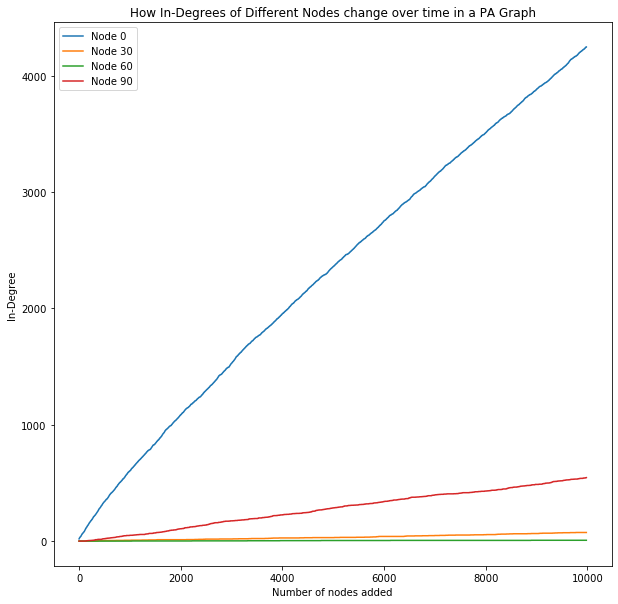

In [30]:
x = [i for i in range(0, 9981)]
y0 = in_degrees_dict[0]
y30 = in_degrees_dict[30]
y60 = in_degrees_dict[60]
y90 = in_degrees_dict[90]

plt.plot(x, y0, label='Node 0')
plt.plot(x, y30, label='Node 30')
plt.plot(x, y60, label='Node 60')
plt.plot(x, y90, label='Node 90')
plt.title('How In-Degrees of Different Nodes change over time in a PA Graph')
plt.xlabel('Number of nodes added')
plt.ylabel('In-Degree')
plt.legend()
plt.rcParams["figure.figsize"] = (10, 10)

# real network: arxiv.org/ftp/arxiv/papers/1509/1509.02006.pdf, bottom of page 2

3. Consider the following network model that constructs a *C graph* with parameters $n$, $m$ and $p$ as follows:
    - Construct a complete graph on $m$ nodes
    - Add $n-m$ further nodes and to each node $v$ add $m$ outgoing edges using the following process for each one:
        * Pick a random node $w$ from the network constructed so far.
        * Either, with probability $p$ add an edge from $v$ to $w$, or
        *  with probability $1-p$ add an edge from $v$ to a neighbour of $w$ chosen at random

Investigate C graphs by generating instances and looking at their properties.  You can choose $n=2000$, $m=20$ and vary $p$.  Comment on your findings.  Do C graphs provide an intuitive model for any real networks?

In [6]:
def create_C_Graph(n, m, p):
    
    # construct complete graph on m nodes
    C_graph = make_complete_graph(m)
    
    # add n - m further nodes
    for vertex in range(m, n):

        neighbours = []  # initialise neighbours of newly added vertex

        # add m outgoing edges
        for edge in range(0, m):

            # select random node w
            current_nodes = list(C_graph)
            w = random.choice(current_nodes)

            random_number = random.random()
            if random_number < p:
                neighbours.append(w)  # add edge from v to w with probability p
            else:
                w_neighbours = list(C_graph[w])
                w_random_neighbour = random.choice(w_neighbours)
                neighbours.append(w_random_neighbour)  # add edge from v to random neighbour of w with probability 1 - p

        C_graph[vertex] = set(neighbours)  # assign vertex and neighbours to the C graph

    return C_graph

In [18]:
# normalises the in degree distribution
def normalise_in_degree_distribution(graph):
    
    in_degrees = in_degree_distribution(graph)
    normalised_in_degree_distribution = {}

    for in_degree in in_degrees:
        normalised_in_degree_distribution[in_degree] = in_degrees[in_degree] / len(graph)
    
    return normalised_in_degree_distribution

In [32]:
# plots the in degree distribution which is based on probability p
def plot_distribution(normalised_distribution, p):
    
    xdata = []
    ydata = []
    
    for degree in normalised_distribution:
        xdata += [degree]
        ydata += [normalised_distribution[degree]]
    
    plt.xlabel('In Degree')
    plt.ylabel('Normalised Rate')
    plt.title('In-Degree Distribution for C graph with probability ' + str(round(p, 1)))
    plt.loglog(xdata, ydata, marker='.', linestyle='None', color='b')
    plt.rcParams["figure.figsize"] = (5, 5)

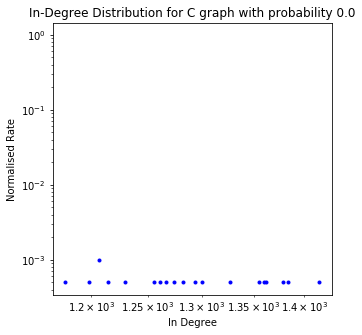

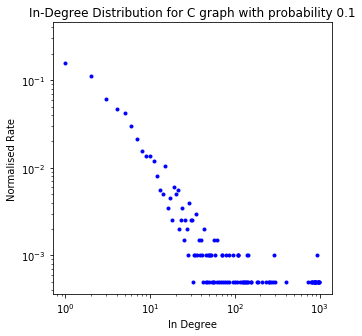

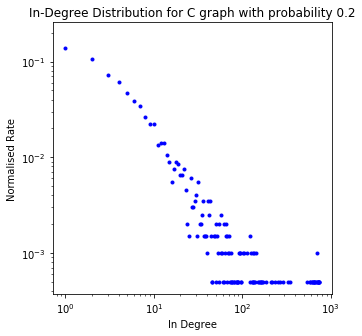

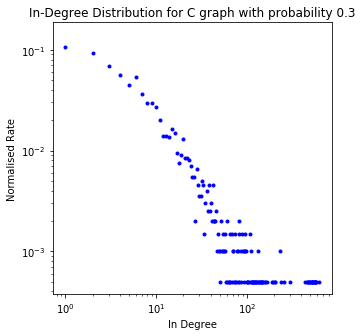

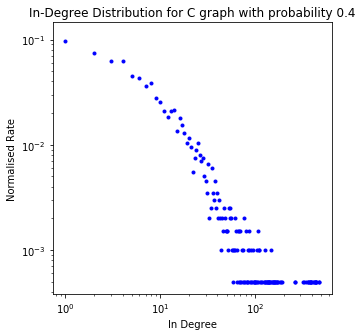

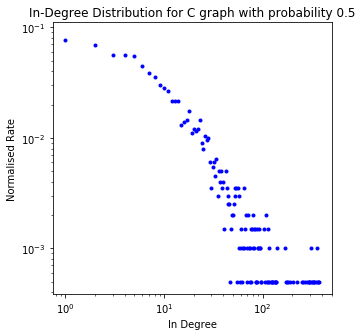

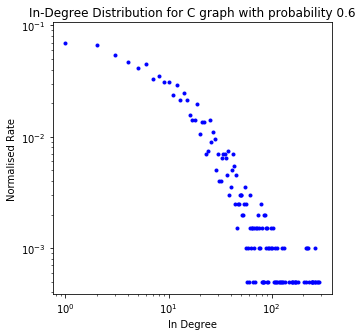

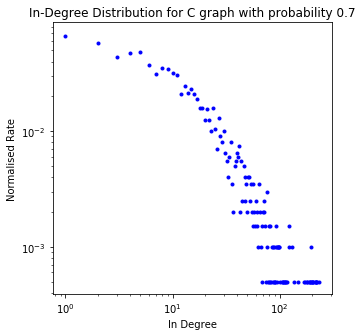

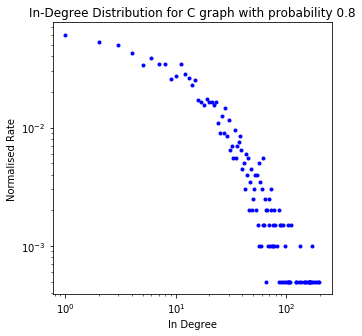

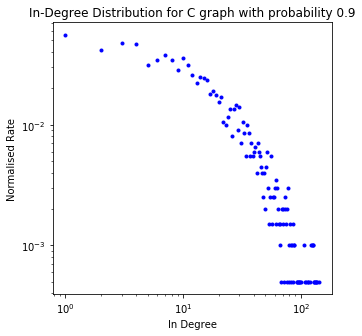

In [33]:
# investigate C graphs by generating instances with p = 0 to p = 1 and plotting in degree distributions
n = 2000
m = 20

for p in np.arange(0, 1, 0.1):
    
    plt.figure()
    C_graph = create_C_Graph(n, m, p)

    normalised = normalise_in_degree_distribution(C_graph)
    plot_distribution(normalised)

You will need to submit all code, plots and written answers for this question.  You can do this most simply by extending this notebook, but you can also, for example, submit py, pdf and image files.  You will be given detailed instructions on the submission for this module before the deadline next term.